In this notebook, we rectify some anomalies.

We had seen in the previous notebook that the percentage of missing values varied for TARGET = 1 and TARGET = 0. To keep the information that the missing values provided, we create new columns which indicate the missing values ( which will later be filled with the median).

We also perform feature engineering:
- A polynomial feature engineering and a feature engineering from domain knowledge.
- These modifications will be stored in 'app_train.csv', 'app_test.csv', 'app_train_poly.csv', 'app_test_poly.csv', 'app_train_domain.csv', 'app_test_domain.csv'.
- We will then build models from these new datasets (in following notebooks) and we will select the one that gives the best result.

# 1. Imports

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

# 2. Load Data

In [2]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
missing = pd.read_csv('missing_target.csv')

In [3]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [4]:
sns.set_theme(style='darkgrid')

# 3. Aligning Training And Testing Data

In [5]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join='inner', axis=1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 122)
Testing Features shape:  (48744, 121)


# 4. Anomalies

In [6]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [7]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, 'Days Employment')

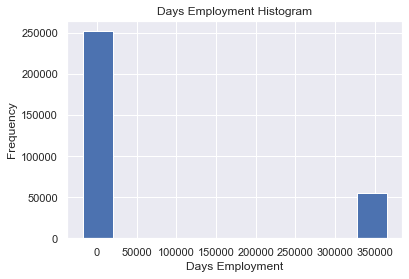

In [8]:
app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

In [9]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Text(0.5, 0, 'Days Employment')

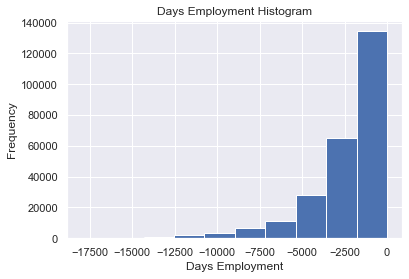

In [10]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)

app_train['DAYS_EMPLOYED'].plot.hist(title='Days Employment Histogram')
plt.xlabel('Days Employment')

In [11]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


# 5. NaN

In [12]:
def col_nan(df, thread):
    col = []
    for i in range(missing.shape[0]):
        if missing['Difference_Percent'][i] > thread:
            col.append(missing['Unnamed: 0'][i])
    for i in col:
        temp = i + '_NaN'
        df[temp] = df[i].isna().astype('boolean')
    return df

In [13]:
app_train = col_nan(app_train, 5)
app_test = col_nan(app_test, 5)

# 6. Feature Engineering

## 6.1. Polynomial Features

In [14]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
imputer = SimpleImputer(strategy='median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns=['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree=3)

In [15]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [16]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

In [17]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns=poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on='SK_ID_CURR', how='left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join='inner', axis=1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 198)
Testing data with polynomial features shape:   (48744, 198)


## 6.2. Domain Knowledge Features

In [18]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [19]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [20]:
app_train_poly.to_csv('app_train_poly.csv', index=False)
app_test_poly.to_csv('app_test_poly.csv', index=False)

In [21]:
app_train_domain.to_csv('app_train_domain.csv', index=False)
app_test_domain.to_csv('app_test_domain.csv', index=False)

In [22]:
app_train.to_csv('app_train.csv', index=False)
app_test.to_csv('app_test.csv', index=False)